In [16]:
from scipy.fftpack import *
from scipy.signal import *
import numpy as np
from fundfunctions import *
pi = np.pi

In [3]:
def gauss(t, fwhm, a, dt):
    return a*np.exp(-4*np.log(2)*((t+dt)/fwhm)**2)

def findN(bw, nch, T):
    N0 = bw*T
    if N0%(2048*nch) == 0:
        return N0
    else:
        return int(np.ceil(N0/(2048*nch))*nch*2048)

def groupedAvg(myArray, N=2):
    result = np.cumsum(myArray, 0)[N-1::N]/float(N)
    result[1:] = result[1:] - result[:-1]
    return result

NANOGrav observations with PUPPI/GUPPI:
Center frequency (MHz)       Bandwidth (MHz)      # of channels
820                          200                  128
1520                         800                  512
2230                         400                  256
-> channel width ~ 1.5 MHz

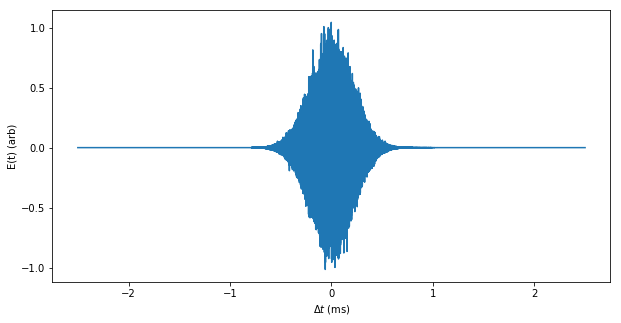

In [305]:
# Starting pulse
T = 5e-3 # period in seconds
fc = 2.23e9 # center frequency in Hz
bw = 400e6 # total bandwidth in Hz
nch = 256 # number of channels
nsam = findN(bw, nch, T) # number of samples
t = np.linspace(-T/2., T/2., nsam) # time axis
dt = T/nsam # sampling interval
template = gauss(t, 5e-4, 1., 0.) # gaussian template
pulse = np.zeros(nsam)
pulse = 0.25*template*rand.randn(nsam)
# pulse = template
# hetpulse = pulse*np.exp(1j*2*pi*t*fc) # heterodyne to center frequency
hetpulse = pulse
plt.figure(figsize = (10, 5))
plt.plot(t*1e3, hetpulse.real)
plt.xlabel(r'$\Delta t$ (ms)')
plt.ylabel('E(t) (arb)')
plt.show()

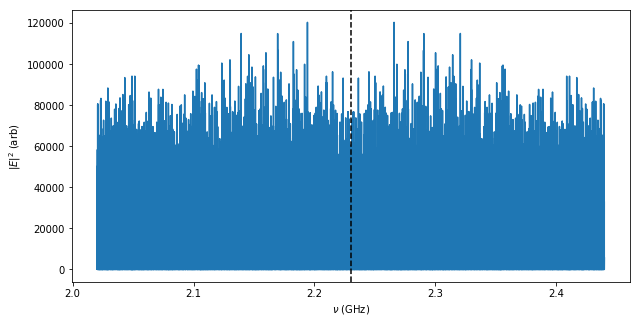

In [306]:
ft = fftshift(fft(hetpulse)) # Fourier transform is centered at fc due to multiplication with exp(iw_0t)
freq = fftfreq(nsam, d = dt)
plt.figure(figsize = (10, 5))
plt.plot(freq/1e9 + fc/1e9, np.abs(ft)**2)
plt.xlabel(r'$\nu$ (GHz)')
plt.ylabel(r'$|E|^2$ (arb)')
plt.axvline(x = fc/1e9, ls = 'dashed', color = 'black')
plt.show()

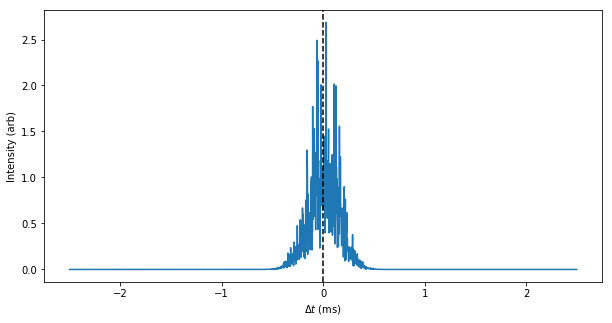

In [307]:
# Pulse associated with a single channel
nfactor = nch/16.
spl = np.split(ft, nch) # split spectrum into segments with length depending on total number of channels
freqs = np.split(freq + fc, nch) 
ift = ifft(ifftshift(spl[0]/nfactor**0.5)) # take inverse Fourier transform using sampled frequencies inside channel
I = groupedAvg(np.abs(ift)**2, N = nsam/(2048*nch)) # average from 8192 bins down to 2048 bins 
# I = I - np.mean(I[:100]) # substract base noise
plt.figure(figsize = (10, 5))
plt.plot(np.linspace(-T/2., T/2., 2048)*1e3, I)
plt.xlabel(r'$\Delta t$ (ms)')
plt.ylabel('Intensity (arb)')
plt.axvline(x = 0, color = 'black', ls = 'dashed')
plt.show()

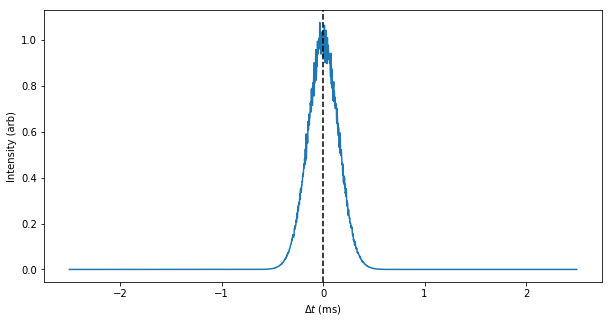

In [308]:
# Average over all channels to construct averaged pulse for entire bandwidth
newpulse = np.zeros(2048)
for i in range(len(spl)):
    ift = ifft(ifftshift(spl[i]))
    I = groupedAvg(np.abs(ift/nfactor**0.5)**2, N = nsam/(2048*nch))
    # I = I - np.mean(I[:100])
    newpulse = newpulse + I
newpulse = newpulse/nch
plt.figure(figsize = (10, 5))
plt.plot(np.linspace(-2.5, 2.5, 2048), newpulse)
plt.axvline(x = 0, color = 'black', ls = 'dashed')
plt.xlabel(r'$\Delta t$ (ms)')
plt.ylabel('Intensity (arb)')
plt.show()

In [309]:
pulse = pp.SinglePulse(newpulse, 256)
pulse.fitPulse(fittemp**2)[1]

0.3712092918621692

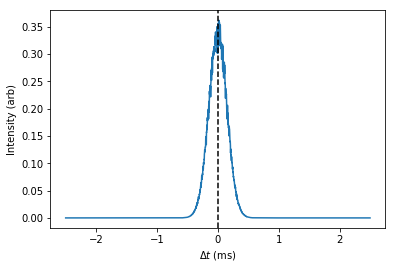

In [258]:
plt.plot(np.linspace(-2.5, 2.5, 2048), accpulse/3.)
plt.axvline(x = 0, color = 'black', ls = 'dashed')
plt.xlabel(r'$\Delta t$ (ms)')
plt.ylabel('Intensity (arb)')
plt.show()

In [215]:
import pypulse as pp
fittemp = gausstemp(np.linspace(-T/2., T/2., 2048), T/10., 1., 0.)

In [318]:
avpulse = np.zeros(2048)
freq = fftfreq(nsam, d = dt)
freqs = np.split(freq + fc, nch) 
for h in range(500):
    pulse = 0.25*template*rand.randn(nsam)
    pulse = pulse*np.exp(1j*2*pi*t*fc)
    ft = fftshift(fft(pulse)) # Fourier transform is centered at fc due to multiplication with exp(iw_0t)
    spl = np.split(ft, nch) # split spectrum into segments with length depending on total number of channels
    newpulse = np.zeros(2048)
    for i in range(len(spl)):
        ift = ifft(ifftshift(spl[i]))
        I = groupedAvg(np.abs(ift/nfactor**0.5)**2, N = nsam/(2048*nch))
        newpulse = newpulse + I
    newpulse = newpulse/nch
    avpulse = avpulse + newpulse
    ptime = pp.SinglePulse(avpulse/(h + 1), 256)
    print(ptime.fitPulse(fittemp**2)[0])

3.5798460176683987e-06
1.7231497693617018e-06
-7.048379873392425e-08
-2.504402429605235e-06
-5.735102194880686e-06
-7.180701030680918e-06
-5.5602214523530374e-06
-2.50938779546239e-06
-4.014255701432872e-06
-6.227004693542546e-06
-6.818703568072401e-06
-7.665490672037268e-06
-7.217532175064516e-06
-7.84178737230364e-06
-7.441953450357068e-06
-8.265657729167298e-06
-8.164870651817625e-06
-7.5036549737876516e-06
-6.118697710277696e-06
-5.816174292878916e-06
-8.246508765197137e-06
-8.030395131964757e-06
-7.915876048050164e-06
-8.163225376235649e-06
-8.78147152859579e-06
-8.28685317186939e-06
-8.05584319498946e-06
-8.492665461262107e-06
-8.602873893075635e-06
-9.162824566373034e-06
-8.250879669845398e-06
-8.460927572044874e-06
-8.266615854934703e-06
-8.358371706400469e-06
-8.787159686400868e-06
-7.611112602414713e-06
-7.917572275622131e-06
-8.561154286948633e-06
-8.229625810857014e-06
-8.24458654705182e-06
-8.471006861313806e-06
-8.840004675072419e-06
-8.585853466481061e-06
-9.262006462165

KeyboardInterrupt: 

In [3]:
T = 5e-3
t = np.linspace(-T/2., T/2., 2048)
fittemp = gausstemp(t, T/10., 1., 0.)
noise = 0.01*(1j*randn(2048) + randn(2048))
delta = unit_impulse(2048, 'mid')

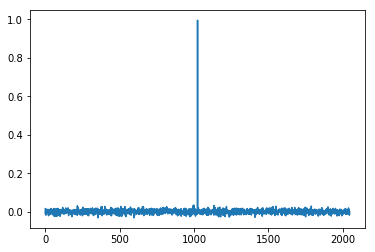

In [4]:
plt.plot(range(2048), noise.real + delta)
plt.show()

In [7]:
conv = convolve(fittemp, np.abs(noise)**2, mode = 'same')

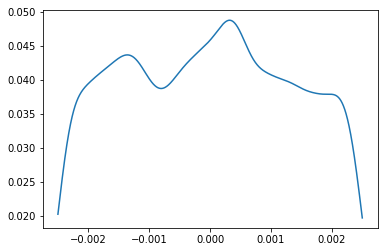

In [8]:
plt.plot(t, conv)
plt.show()

In [11]:
conv2 = fftshift(ifft(fft(fittemp)*fft(np.abs(noise)**2)))

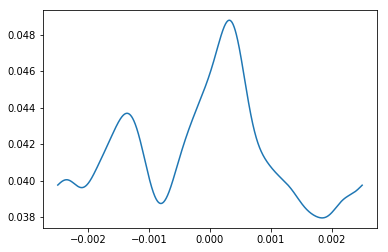

In [12]:
plt.plot(t, conv2)
plt.show()

In [13]:
np.sqrt(-5 + 0j)

2.23606797749979j

In [6]:
a = 1
np.exp(1j*np.angle(a))

(1+0j)

In [3]:
np.exp(1j*np.angle(np.conj(a)))

(0.5449883505954142-0.8384436163006371j)

In [27]:
np.angle(np.conj(a))

-0.8567056281827387

In [8]:
1 + (1. + 2j)

(2+2j)

In [2]:
a = 3 + 2j

In [17]:
np.angle(1./a**0.5)

-0.29400130177378375

In [12]:
np.angle(np.conj(a))

-0.5880026035475675

In [3]:
a**-0.5

(0.5040433160363529-0.15261203645745605j)

In [5]:
(-3 + 2j)**-0.5

(0.15261203645745605-0.5040433160363529j)

In [6]:
np.angle(a)

0.5880026035475675

In [9]:
pi + np.angle(-3 - 2j)

0.5880026035475674

In [11]:
a = 3 + 2j
b = np.conj(a)
[a**-0.5, -b**-0.5]

[(0.5040433160363529-0.15261203645745605j),
 (-0.5040433160363528-0.15261203645745602j)]

In [15]:
d = a**-0.5
(-d)**-2

(2.9999999999999996+1.9999999999999998j)

In [29]:
delta = unit_impulse(8193, 'mid')
ft = fftshift(rfft(delta))

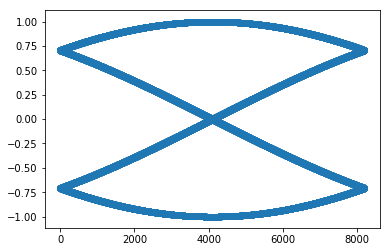

In [30]:
plt.scatter(range(8193), ft)
plt.show()

In [25]:
ft

array([ 0.00019172-0.99999998j, -0.00057517+0.99999983j,
        0.00095862-0.99999954j, ...,  0.00095862+0.99999954j,
       -0.00057517-0.99999983j,  0.00019172+0.99999998j])

In [26]:
delta

array([0., 0., 0., ..., 0., 0., 0.])